# Byte N-gram LM Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from transduction.lm.ngram import ByteNgramLM

## Train on some text

In [4]:
corpus = b"""
the cat sat on the mat. the dog sat on the log.
the cat chased the dog. the dog chased the cat.
a bird flew over the lazy dog. the quick brown fox jumped.
the cat is on the mat. the dog is on the log.
""" * 10  # repeat for more counts

lm = ByteNgramLM.train(corpus, n=4, alpha=0.01)
print(lm)

ByteNgramLM(n=4, contexts=201)


## Basic interface

In [ ]:
state = lm >> b't'

# Advance one byte at a time
for ch in b'he ':
    state = state >> bytes([ch])

print(state)
print(f'Cumulative logp: {state.logp:.3f}')
print()

# Top predictions
top = state.logp_next.materialize(top=10)
for tok, lp in top.items():
    print(f'  {tok!r:6s}  logp={lp:+.2f}  p={np.exp(lp):.3f}')

## Sampling

In [ ]:
b''.join(lm(b'the ').sample_decode())

## Score a string

In [ ]:
def score(lm, text):
    if isinstance(text, str): text = text.encode()
    state = lm(text)
    return state.logp

texts = [
    b'the cat sat on the mat.',
    b'the dog sat on the log.',
    b'the cat sat on the log.',   # mixed
    b'xyzzy plugh grault.',       # nonsense
]

for t in texts:
    lp = score(lm, t)
    print(f'  logp={lp:+8.2f}  ppl={np.exp(-lp/len(t)):8.1f}  {t!r}')

## Train on WikiText

In [11]:
from transduction.applications.wikitext import load_wikitext

# Collect training text
chunks = []
for item in load_wikitext('train'):
    text = item['text'].strip()
    if text:
        chunks.append(text.encode('utf-8'))
    if sum(len(c) for c in chunks) > 1_000_000:
        break

train_data = b'\n'.join(chunks)
print(f'Training data: {len(train_data):,} bytes')

lm_wiki = ByteNgramLM.train(train_data, n=5, alpha=0.001)
print(lm_wiki)

Training data: 1,002,885 bytes
ByteNgramLM(n=5, contexts=71699)


In [ ]:
for prompt in [b'The ', b'In 200', b'He was ']:
    decoded = b''.join(lm_wiki(prompt).greedy_decode(max_len=80))
    print(f'{prompt!r:12s} -> {decoded!r}')
print()
for _ in range(5):
    sampled = b''.join(lm_wiki(b'The ').sample_decode(max_len=80))
    print(f'  {sampled!r}')

## Prioritized enumeration: lowercase FST

Given a target lowercase string, find the most likely mixed-case input under the WikiText n-gram LM.

In [15]:
from transduction.fst import FST
from transduction.rust_bridge import RustDecomp
from transduction.enumeration import prioritized_enumeration

# Byte-level lowercase FST: maps uppercase ASCII bytes to lowercase,
# passes lowercase and space through unchanged.
# Uses bytes labels to match ByteNgramLM's vocabulary.
def byte_lowercase_fst():
    fst = FST()
    fst.add_start(0)
    fst.add_stop(0)
    for i in range(256):
        c = chr(i) if i < 128 else None
        if c and c.isalpha():
            lo = ord(c.lower())
            fst.add_arc(0, bytes([i]), bytes([lo]), 0)
        elif c == ' ':
            fst.add_arc(0, bytes([i]), bytes([i]), 0)
    return fst

fst = byte_lowercase_fst()
print(f'Lowercase FST: {len(fst.states)} state, {len(fst.A)} input symbols, {len(fst.B)} output symbols')

Lowercase FST: 1 state, 53 input symbols, 27 output symbols


In [16]:
# Target: "in january" — appears in WikiText as "in January"
target_str = b'in january'
target = tuple(bytes([b]) for b in target_str)

# Decompose
result = RustDecomp(fst, target)
Q, R = result.quotient, result.remainder
print(f'Target: {target_str!r}')
print(f'Q: {len(Q.states)} states, {len(Q.stop)} final')
print(f'R: {len(R.states)} states, {len(R.stop)} final')

# Enumerate: find the most likely mixed-case inputs that lowercase to target_str
pe = prioritized_enumeration(lm_wiki.initial(), fst, target, max_steps=100000, 
                             decompose=RustDecomp)

print(f'\nFound {len(pe.quotient_terms)} quotient, {len(pe.remainder_terms)} remainder')
print(f'\nMost likely inputs that lowercase to {target_str!r}:')
all_terms = sorted(pe.quotient_terms + pe.remainder_terms, key=lambda x: -x.weight)
for item in all_terms[:10]:
    kind = 'Q' if item in pe.quotient_terms else 'R'
    input_bytes = item.source.path_bytes()
    print(f'  [{kind}] logp={item.weight:+.3f}  {input_bytes}')

Target: b'in january'
Q: 11 states, 1 final
R: 11 states, 0 final

Found 512 quotient, 0 remainder

Most likely inputs that lowercase to b'in january':
  [Q] logp=-11.484  b'in January'
  [Q] logp=-13.102  b'In January'
  [Q] logp=-22.417  b'in JanuarY'
  [Q] logp=-24.036  b'In JanuarY'
  [Q] logp=-27.614  b'in JanuaRy'
  [Q] logp=-29.233  b'In JanuaRy'
  [Q] logp=-30.427  b'in JanuAry'
  [Q] logp=-32.045  b'In JanuAry'
  [Q] logp=-34.560  b'IN January'
  [Q] logp=-36.295  b'in jAnuary'


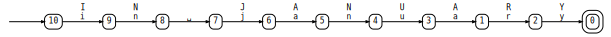

In [17]:
Q.min().graphviz(fmt_edge=lambda i,a,j: a.decode('latin-1').replace(' ', '␣'))